In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)


In [48]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.9" 2020-10-20
OpenJDK Runtime Environment (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1, mixed mode, sharing)


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip 

In [4]:
#import zipfile
#path_to_zip_file = '/content/drive/My Drive/arXiv/mallet-2.0.8.zip'

#print ('Extracting',path_to_zip_file)

#with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#  zip_ref.extractall('.')

#print()
#print('Here is a directory listing (you should see a directory with your corpus):')
#!ls -l

Extracting /content/drive/My Drive/arXiv/mallet-2.0.8.zip

Here is a directory listing (you should see a directory with your corpus):
total 12
drwx------  5 root root 4096 Nov  2 13:13 drive
drwxr-xr-x 10 root root 4096 Nov  2 13:14 mallet-2.0.8
drwxr-xr-x  1 root root 4096 Oct 28 16:30 sample_data


In [50]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' 

In [ ]:
!ls mallet-2.0.8

bin	   class  lib	   Makefile  README.md	  src	     test
build.xml  dist   LICENSE  pom.xml   sample-data  stoplists


In [5]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' 

In [6]:
mallet_path

'/content/mallet-2.0.8/bin/mallet'

In [ ]:
!pip install pyLDAvis
!pip install nltk

In [8]:
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

import spacy
from nltk.corpus import stopwords

# for plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [9]:
gensim.__version__

'3.8.3'

In [10]:
df = pd.read_csv("/content/drive/My Drive/arXiv/papers_noun_phrases.csv")

In [11]:
!ls 

drive  mallet-2.0.8  sample_data


In [12]:
df['noun_phrases'] = df['noun_phrases'].str.strip()
# Convert to list
data = df.noun_phrases.values.tolist()

In [13]:
# NLTK Stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [15]:
%%time
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_phraser = gensim.models.phrases.Phraser(bigram)
trigram_phraser = gensim.models.phrases.Phraser(trigram)

CPU times: user 1min 21s, sys: 417 ms, total: 1min 21s
Wall time: 1min 21s


In [16]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_phraser[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_phraser[bigram_phraser[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:
%%time
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams)

CPU times: user 6min 3s, sys: 2.09 s, total: 6min 5s
Wall time: 6min 6s


In [18]:
%%time
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 3), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1)]]
CPU times: user 8.43 s, sys: 208 ms, total: 8.63 s
Wall time: 8.64 s


In [54]:
import pickle 

with open('/content/drive/My Drive/arXiv/models.pickle', 'rb') as f:
    models = pickle.load(f)

with open('/content/drive/My Drive/arXiv/coherence_values.pickle', 'rb') as f:
    coherence_values = pickle.load(f)
    

with open('/content/drive/My Drive/arXiv/models_noun.pickle2', 'rb') as f:
    models_nouns = pickle.load(f)

with open('/content/drive/My Drive/arXiv/coherence_values_noun.pickle', 'rb') as f:
    coherence_values_nouns = pickle.load(f)


with open('/content/drive/My Drive/arXiv/models_all.pickle', 'rb') as f:
    models_full = pickle.load(f)

with open('/content/drive/My Drive/arXiv/coherence_values_all.pickle', 'rb') as f:
    coherence_values_full = pickle.load(f)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


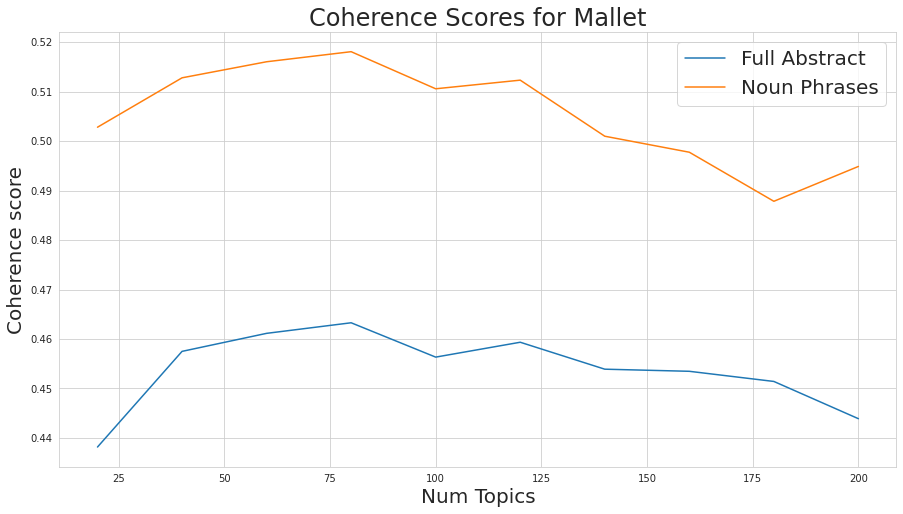

In [55]:
## Plot the coherence scores for different N topics
### Select optimum N

import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['font.sans-serif'] = "Georgia"

# Show graph
plt.figure(figsize=(15, 8))
limit=201; start=20; step=20;
x = range(start, limit, step)
plt.plot(x,  coherence_values_full, label='Full Abstract')
plt.plot(x, coherence_values_nouns, label='Noun Phrases')
plt.xlabel("Num Topics", fontsize=20)
plt.ylabel("Coherence score", fontsize=20)
plt.legend(fontsize=20)
plt.title('Coherence Scores for Mallet', fontsize=24)
plt.show()

In [56]:
# Print the coherence scores
for m, cv in zip(x, coherence_values_nouns):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 20  has Coherence Value of 0.5028
Num Topics = 40  has Coherence Value of 0.5128
Num Topics = 60  has Coherence Value of 0.516
Num Topics = 80  has Coherence Value of 0.5181
Num Topics = 100  has Coherence Value of 0.5106
Num Topics = 120  has Coherence Value of 0.5123
Num Topics = 140  has Coherence Value of 0.501
Num Topics = 160  has Coherence Value of 0.4978
Num Topics = 180  has Coherence Value of 0.4878
Num Topics = 200  has Coherence Value of 0.4949


In [58]:
from pprint import pprint

# Select the model and print the topics
optimal_model = models_nouns[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.046*"knowledge" + 0.027*"set" + 0.023*"question" + 0.021*"approach" + '
  '0.019*"event" + 0.019*"process" + 0.017*"paper" + 0.015*"concept" + '
  '0.014*"rule" + 0.013*"case" + 0.013*"work" + 0.013*"form" + 0.012*"problem" '
  '+ 0.012*"result" + 0.012*"type" + 0.011*"simple" + 0.011*"theory" + '
  '0.010*"explanation" + 0.009*"program" + 0.009*"general"'),
 (1,
  '0.140*"feature" + 0.074*"information" + 0.049*"level" + '
  '0.048*"representation" + 0.044*"attention" + 0.028*"local" + '
  '0.025*"temporal" + 0.023*"spatial" + 0.020*"art" + 0.018*"mechanism" + '
  '0.018*"global" + 0.016*"experiment" + 0.015*"propose" + 0.015*"module" + '
  '0.013*"context" + 0.012*"extensive" + 0.012*"multi" + 0.012*"semantic" + '
  '0.010*"fusion" + 0.010*"modality"'),
 (2,
  '0.043*"state" + 0.043*"policy" + 0.041*"agent" + 0.036*"learn" + '
  '0.034*"environment" + 0.034*"action" + 0.032*"dynamic" + '
  '0.024*"reinforcement" + 0.022*"control" + 0.022*"learning" + 0.018*"human" '
  '+ 0.0

In [61]:
optimal_model.__dict__

{'alpha': array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
        2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]),
 'id2word': <gensim.corpora.dictionary.Dictionary at 0x7f014408f470>,
 'iterations': 1000,
 'mallet_path': '/kaggle/working/./mallet-2.0.8/bin/mallet',
 'num_terms': 44390,
 'num_topics': 20,
 'optimize_interval': 0,
 'prefix': '/tmp/d07172_',
 'random_seed': 0,
 'topic_threshold': 0.0,
 'word_topics': array([[  0.,  43.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [482.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   1., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]),
 'wordtopics': array([[  0.,  43.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [482.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   1., ...,   0.,   0.,   0.],
        [  0.,   0

In [62]:
optimal_model.mallet_path = mallet_path

In [69]:
%%time
def run_model(dictionary, corpus, texts, num_topics):
  model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
  coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence_value = coherencemodel.get_coherence()
  return model, coherence_value

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [70]:
%%time
model, coherence_value = run_model(dictionary=id2word, corpus=corpus, texts=data_lemmatized, num_topics=20)

CPU times: user 32 s, sys: 365 ms, total: 32.4 s
Wall time: 9min 4s


In [73]:
coherence_value2

0.5019318690514883

In [75]:
%%time
model2, coherence_value2 = run_model(dictionary=id2word, corpus=corpus, texts=data_lemmatized, num_topics=30)
coherence_value2

CPU times: user 39.1 s, sys: 349 ms, total: 39.5 s
Wall time: 9min 40s


In [77]:
coherence_value2

0.5156137825875471

In [83]:
%%time
model3, coherence_value3 = run_model(dictionary=id2word, corpus=corpus, texts=data_lemmatized, num_topics=40)
coherence_value3

CPU times: user 48.4 s, sys: 536 ms, total: 48.9 s
Wall time: 10min 20s


In [84]:
coherence_value3

0.5139128899418968

In [85]:
%%time
model4, coherence_value4 = run_model(dictionary=id2word, corpus=corpus, texts=data_lemmatized, num_topics=60)


CPU times: user 53 s, sys: 474 ms, total: 53.5 s
Wall time: 11min 5s


In [86]:
coherence_value4

0.5301987328015918

In [87]:
%%time
model5, coherence_value5 = run_model(dictionary=id2word, corpus=corpus, texts=data_lemmatized, num_topics=100)

CPU times: user 1min 11s, sys: 602 ms, total: 1min 12s
Wall time: 12min 43s


In [88]:
coherence_value5

0.5139069851722362

In [90]:
p = pyLDAvis.gensim.prepare(model_to_viz, corpus, id2word)
pyLDAvis.save_html(p, '/content/drive/My Drive/arXiv/lda60.html')

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


In [89]:
# Visualize the topics

model_to_viz = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model4)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_to_viz, corpus, id2word)
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
36     0.032218 -0.110723       1        1  1.920705
8      0.105237 -0.162175       2        1  1.913236
42     0.135403  0.007998       3        1  1.855525
25     0.038689  0.001232       4        1  1.842031
2      0.083178 -0.113293       5        1  1.802406
49     0.098097 -0.017941       6        1  1.793610
41     0.067339 -0.039510       7        1  1.793193
15    -0.086629 -0.115846       8        1  1.779840
24     0.122945 -0.065233       9        1  1.764765
4     -0.231839  0.073982      10        1  1.754085
22     0.094355 -0.049766      11        1  1.751533
35    -0.161379 -0.082855      12        1  1.720576
47    -0.031571 -0.137278      13        1  1.707763
52     0.013970 -0.158385      14        1  1.705918
27     0.093983 -0.153792      15        1  1.705312
1     -0.169716  0.088202      16        1  1.700830
59     0.091835  0.141525      17        1  1.694043
30     0.142717  0.229251      18        1  1.693691
28     0.112230 -0.048915      19        1  1.693033
32    -0.267162  0.039813      20        1  1.683459
55     0.100706 -0.055465      21        1  1.682086
44     0.035525  0.162575      22        1  1.681546
50     0.035653  0.077352      23        1  1.680950
11    -0.040809 -0.079234      24        1  1.675609
40    -0.076989 -0.114359      25        1  1.673856
7     -0.021959 -0.072437      26        1  1.669593
39    -0.063865 -0.148105      27        1  1.668836
16    -0.219154  0.038122      28        1  1.667825
31     0.043600 -0.096715      29        1  1.665693
19    -0.095779 -0.135807      30        1  1.662715
54     0.105175  0.031379      31        1  1.655317
14     0.105694 -0.081753      32        1  1.654548
48     0.085279  0.014401      33        1  1.647665
29    -0.108494 -0.079042      34        1  1.639998
6     -0.002969  0.005611      35        1  1.638499
51     0.124186  0.022600      36        1  1.638468
3      0.095722 -0.049826      37        1  1.638358
33     0.139407  0.157310      38        1  1.630458
46    -0.069280  0.072989      39        1  1.619737
17    -0.136094  0.091856      40        1  1.617782
58    -0.140901 -0.114022      41        1  1.610130
21     0.068971 -0.001399      42        1  1.609426
5     -0.203106  0.103392      43        1  1.605278
56    -0.094815  0.038717      44        1  1.599197
10    -0.145144 -0.039736      45        1  1.597370
13    -0.031782 -0.028490      46        1  1.595637
57    -0.081811  0.021328      47        1  1.591285
45    -0.069667 -0.096562      48        1  1.590335
18     0.021270  0.008007      49        1  1.588440
26     0.076062 -0.045317      50        1  1.587686
23     0.046028  0.132342      51        1  1.584062
34     0.079012  0.149840      52        1  1.583106
9      0.042705  0.197656      53        1  1.582321
37     0.086814  0.072813      54        1  1.579844
20     0.076008  0.101287      55        1  1.571052
53     0.131385  0.007582      56        1  1.566585
12    -0.034935  0.104743      57        1  1.565253
38     0.124441  0.024056      58        1  1.558515
43    -0.128943  0.225313      59        1  1.529149
0     -0.141050  0.050706      60        1  1.520238, topic_info=           Term          Freq         Total Category  logprob  loglift
19        model  78230.000000  78230.000000  Default  30.0000  30.0000
94      network  49759.000000  49759.000000  Default  29.0000  29.0000
54       method  53236.000000  53236.000000  Default  28.0000  28.0000
309       image  44535.000000  44535.000000  Default  27.0000  27.0000
279        task  33402.000000  33402.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
301      system    605.929704  20663.711914  Topic60  -4.5827   0.6569
158        work    498.751245  19065.138895  Topic60  -4.7774   0.5428
46   experiment    466.916059  1

### Dominant topic in each document and topic weight

Each document (here, each data point) can be composed of multiple topics. But generally there one dominant topic, let's extract that.

In [94]:
%%time
def format_topics_sentences(ldamodel=model4, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=model4, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

CPU times: user 5min 23s, sys: 5.34 s, total: 5min 28s
Wall time: 6min 22s


In [98]:
df_dominant_topic.Dominant_Topic.value_counts()

24.0    2527
31.0    2419
49.0    2199
28.0    1848
52.0    1766
36.0    1750
39.0    1745
13.0    1745
55.0    1678
7.0     1566
21.0    1537
11.0    1438
47.0    1434
30.0    1388
27.0    1387
42.0    1384
29.0    1353
0.0     1351
33.0    1345
14.0    1250
54.0    1241
53.0    1222
38.0    1200
20.0    1188
25.0    1118
45.0    1052
51.0    1043
41.0     988
26.0     988
10.0     976
59.0     939
15.0     929
3.0      901
37.0     897
56.0     839
8.0      819
48.0     811
18.0     775
23.0     735
46.0     691
9.0      652
58.0     630
12.0     629
43.0     618
44.0     600
50.0     592
40.0     572
19.0     566
34.0     538
6.0      532
2.0      496
16.0     448
5.0      350
57.0     327
35.0     315
22.0     255
32.0     230
4.0      220
17.0     206
1.0      187
Name: Dominant_Topic, dtype: int64

In [120]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype(float).astype(int).astype(str)

df_dominant_topic.head()


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,20,0.0673,"concept, rule, query, tree, program, set, paper, knowledge, order, reasoning","['Message', 'algorithms', 'hard constraint satisfaction problems', 'sparse random graphs', 'such..."
1,1,54,0.0824,"distribution, sample, probability, uncertainty, estimator, estimation, sampling, density, estima...","['Dependence strucuture estimation', 'the important problems', 'machine learning', 'domain', 'ma..."
2,2,37,0.0915,"group, individual, decision, bias, risk, impact, negative, fairness, positive, case","['EVOC', 'EVOlution', 'Culture', 'a computer model', 'culture', 'us', 'how various factors', 'ba..."
3,3,26,0.0824,"human, interaction, behavior, game, expert, work, ability, player, people, team","['A perceived limitation', 'evolutionary art', 'design algorithms', 'they', 'human intervention'..."
4,4,26,0.1287,"human, interaction, behavior, game, expert, work, ability, player, people, team","['It', 'creativity', 'the self-mending capacity', 'an internal model', 'the world', 'worldview',..."


In [118]:
df_dominant_topic.dtypes

Document_No             int64
Dominant_Topic         object
Topic_Perc_Contrib    float64
Keywords               object
Text                   object
dtype: object

In [112]:
df.head(10)

,Unnamed: 0,abstract,id,title,noun_phrases
0,0,Message passing algorithms have proved surprisingly successful in solving hard constraint satisf...,0709.1667,Solving Constraint Satisfaction Problems through Belief Propagation-guided decimation,"['Message', 'algorithms', 'hard constraint satisfaction problems', 'sparse random graphs', 'such..."
1,1,Dependence strucuture estimation is one of the important problems in machine learning domain and...,0804.4451,Dependence Structure Estimation via Copula,"['Dependence strucuture estimation', 'the important problems', 'machine learning', 'domain', 'ma..."
2,2,EVOC (for EVOlution of Culture) is a computer model of culture that enables us to investigate ho...,0811.2551,Modeling Cultural Dynamics,"['EVOC', 'EVOlution', 'Culture', 'a computer model', 'culture', 'us', 'how various factors', 'ba..."
3,3,A perceived limitation of evolutionary art and design algorithms is that they rely on human inte...,1001.1401,Incorporating characteristics of human creativity into an evolutionary art algorithm,"['A perceived limitation', 'evolutionary art', 'design algorithms', 'they', 'human intervention'..."
4,4,It is hypothesized that creativity arises from the self-mending capacity of an internal model of...,1005.1518,Recognizability of Individual Creative Style Within and Across Domains: Preliminary Studies,"['It', 'creativity', 'the self-mending capacity', 'an internal model', 'the world', 'worldview',..."
5,5,We consider the problem of online linear regression on individual sequences. The goal in this pa...,1105.4042,Adaptive and optimal online linear regression on $\ell^1$-balls,"['We', 'the problem', 'online linear regression', 'individual sequences', 'The goal', 'this pape..."
6,6,Gradient-based approaches to direct policy search in reinforcement learning have received much r...,1106.0665,Infinite-Horizon Policy-Gradient Estimation,"['Gradient-based approaches', 'direct policy search', 'reinforcement learning', 'much recent att..."
7,7,"In this paper, we present algorithms that perform gradient ascent of the average reward in a par...",1106.0666,"Experiments with Infinite-Horizon, Policy-Gradient Estimation","['this paper', 'we', 'algorithms', 'gradient ascent', 'the average reward', 'a partially observa..."
8,8,We begin this chapter with the bold claim that it provides a neuroscientific explanation of the ...,1106.3600,"How Insight Emerges in a Distributed, Content-addressable Memory","['We', 'this chapter', 'the bold claim', 'it', 'a neuroscientific explanation', 'the magic', 'cr..."
9,9,Purely data driven approaches for machine learning present difficulties when data is scarce rela...,1107.2699,Linear Latent Force Models using Gaussian Processes,"['Purely data driven approaches', 'present difficulties', 'data', 'the complexity', 'the model',..."


In [121]:
final_df = df.merge(df_dominant_topic, left_on='Unnamed: 0', right_on='Document_No')

In [122]:
to_export = final_df[['id','Dominant_Topic','title']]

In [124]:
len(df)

61425

In [125]:
#to_export.to_csv("/content/drive/My Drive/arXiv/extracted_topics.csv", index=False)

In [95]:
%%time
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

CPU times: user 117 ms, sys: 991 µs, total: 118 ms
Wall time: 120 ms


In [100]:
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.3207,"noise, signal, speech, audio, performance, end, noisy, recognition, result, emotion","['This paper', 'an unsupervised segment-based method', 'robust voice activity detection', '(rVAD..."
1,1.0,0.2024,"approach, base, propose, exist, work, result, limitation, traditional, advantage, paper","['the emergence', 'high-resolution fingerprint sensors', 'a lot', 'focus', 'level-3 fingerprint ..."
2,2.0,0.1931,"learning, learn, deep, machine, technique, active, traditional, application, success, supervise","['semantically identical questions', 'Question', 'Answering', 'social media platforms', 'Quora',..."
3,3.0,0.2627,"time, sequence, dynamic, state, recurrent, temporal, series, sequential, step, long","['The accurate seasonal and trend forecasting', 'tourist arrivals', 'a very challenging task', '..."
4,4.0,0.1887,"method, propose, base, exist, result, experimental, experiment, traditional, paper, effectiveness","['this paper', 'a novel image enhancement network', 'HDR images', 'training data', 'our network'..."


## Frequency Distribution of Word Counts in Documents

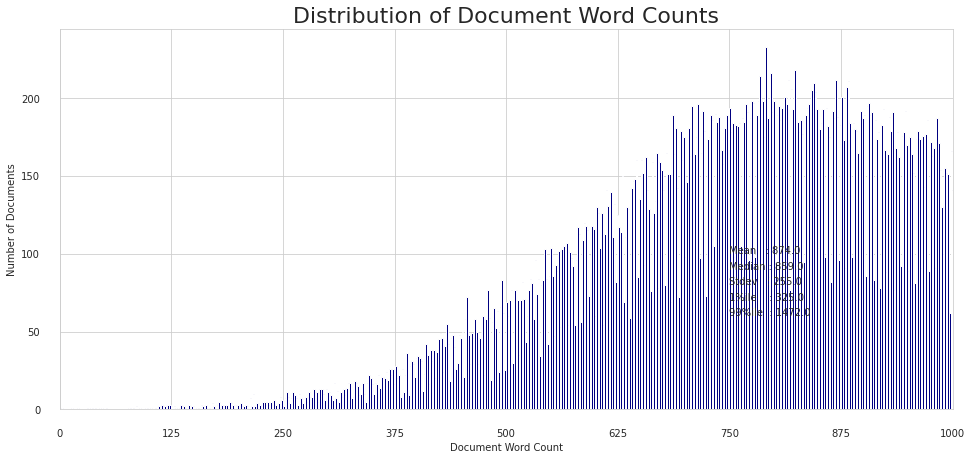

In [102]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7))
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [103]:
optimal_model = model4

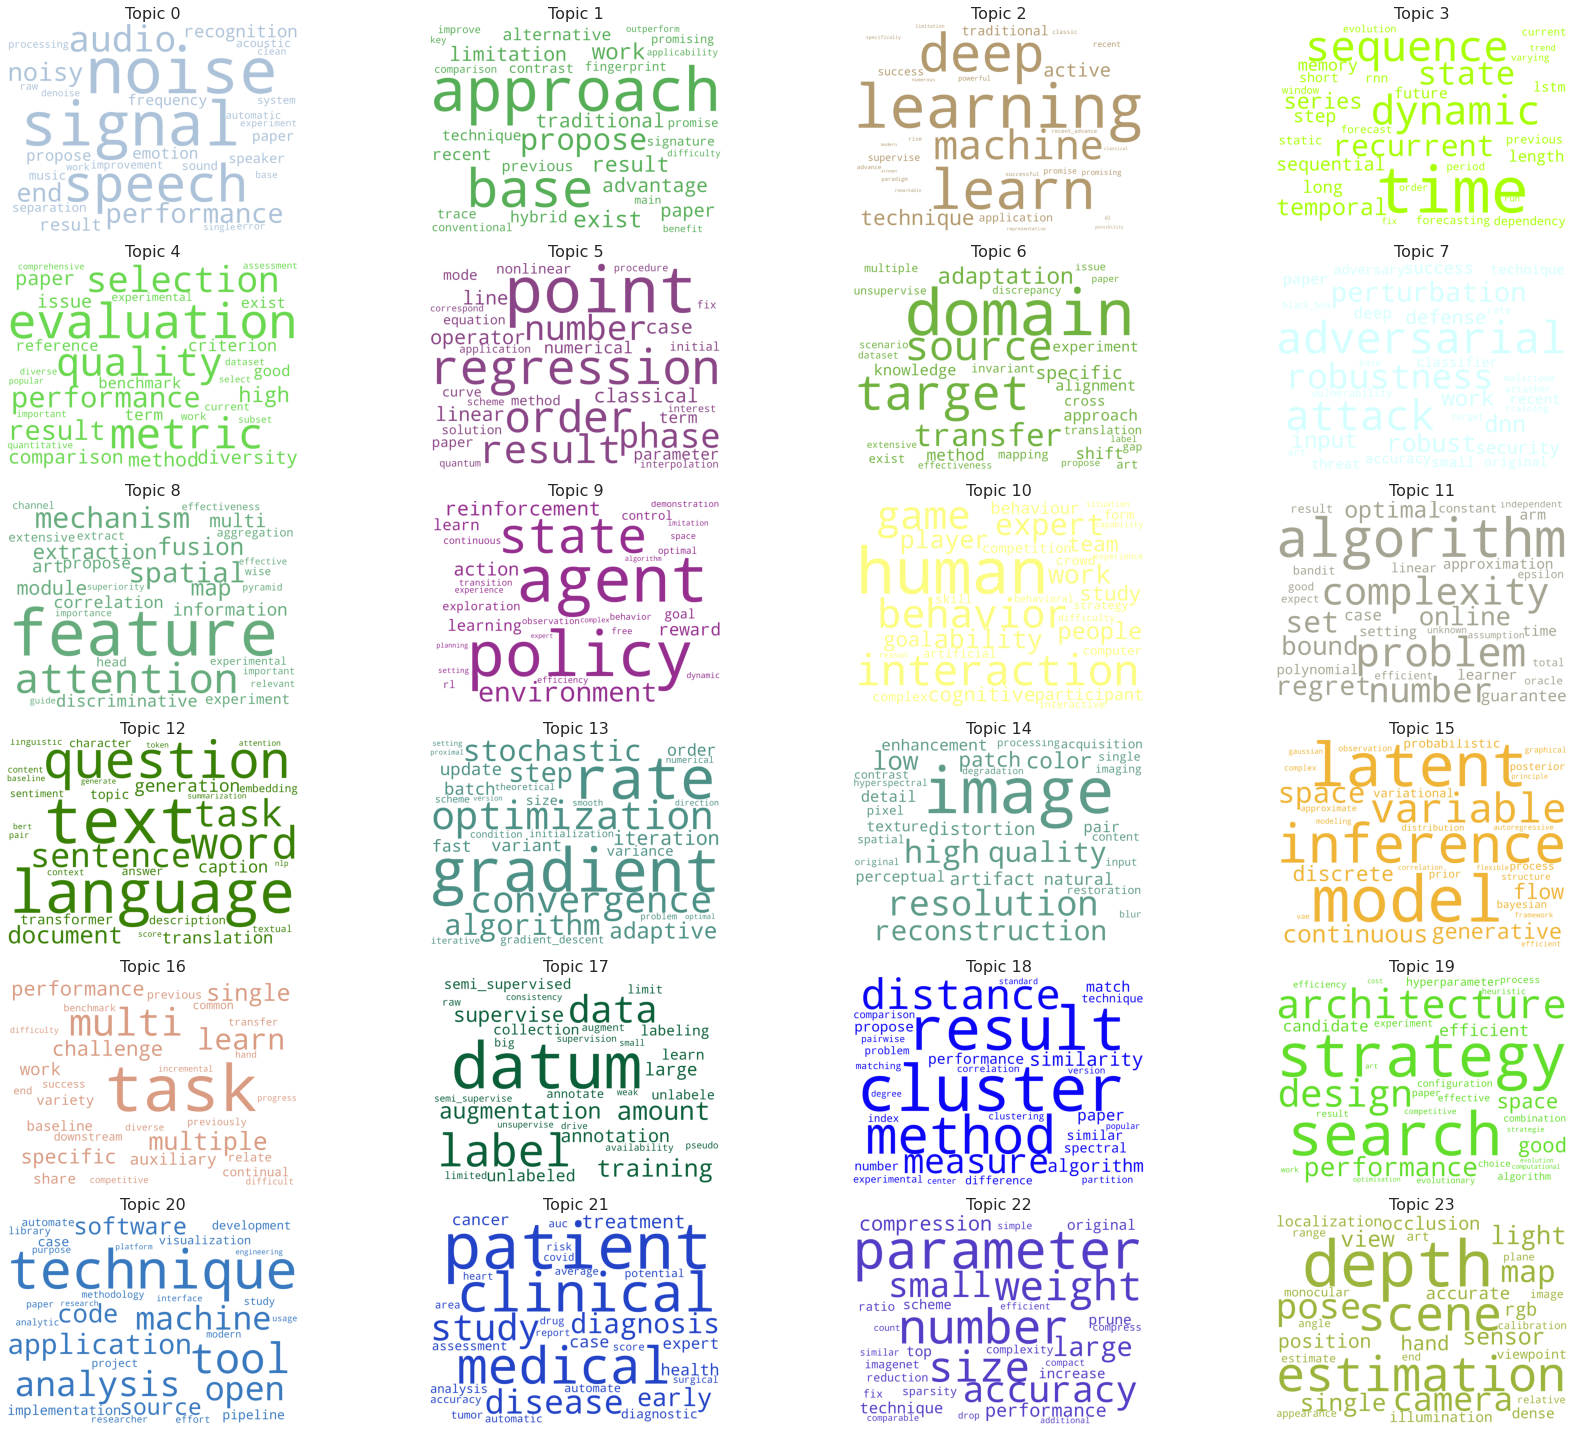

In [110]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'


cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='paired',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=30, num_words=30)
topics.sort(key=lambda tup: tup[0])

fig, axes = plt.subplots(6, 4, figsize=(25,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=550)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()